In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from fractions import Fraction as frac
import numpy as np
import pandas as pd
import csv
import itertools

# e_coli_core

### Visualize all ECMs

In [69]:
ecm_df = pd.read_csv('../simple_networks/ecms/results/e_coli_core_ecm_df.csv', index_col=0)

# Convert stoichiometry to fractions, THEN convert to floats
ecm_df = ecm_df.applymap(frac)
ecm_df = ecm_df.applymap(float)

# Filter rows according to sign of metabolite exchange
ecm_df = np.sign(ecm_df)
ecm_df = ecm_df.drop_duplicates()

# Filter away unused metabolites
ecm_df = ecm_df.loc[:, (ecm_df != 0).any(axis = 0)]

# Filter ECMs that produce biomass
ecm_df = ecm_df.loc[ecm_df['objective'] != 0]

# Remove column with biomass
ecm_df = ecm_df.drop('objective', axis = 1)

In [70]:
# Make informational column names i.e. translate metabolite ID to metabolite name

# Read translation file
metabfile = open('raw_data_from_publications/metabolite_names_e_coli_core.txt')
metabnames = metabfile.readlines()

# Make ID:name dictionary
id_to_name = dict()
for line in metabnames:
    id_to_name[line.split()[1]] = ' '.join(line.split()[2:-2])

# Edit some names manually. All names must coincide with metabolite names for MPs.
id_to_name['M_h2o_e'] = 'H2O'
id_to_name['M_co2_e'] = 'CO2'
id_to_name['M_o2_e'] = 'O2'
id_to_name['M_urea_e'] = 'Urea'
    
# Subset column names
column_names = {ID: id_to_name[ID] for ID in ecm_df.columns}

# Rename all columns
ecm_df = ecm_df.rename(columns=column_names)

In [71]:
ecm_df.shape

(346, 16)

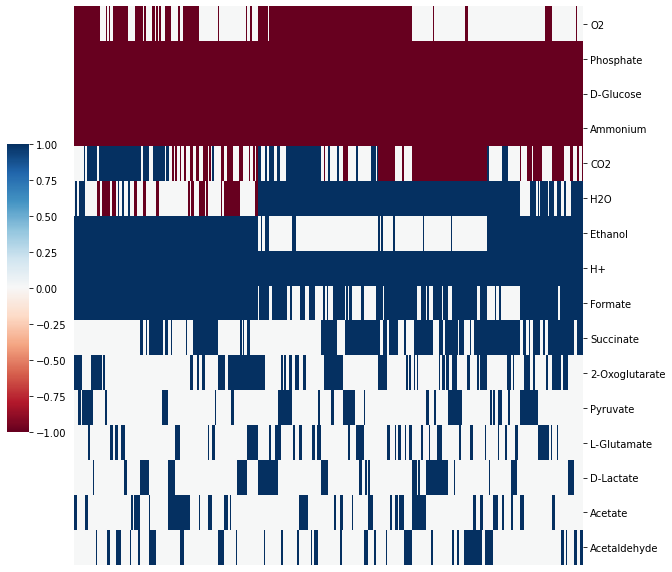

In [72]:
# Render figure
cmap = sns.clustermap(ecm_df.T, cmap='RdBu',xticklabels=0)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)
cmap.fig.subplots_adjust(right=0.9)
cmap.ax_cbar.set_position((0.1, .2, .03, .4))
plt.savefig('results/figures/ecms_ecolic', bbox_inches='tight')

### Visualize all MPs

In [73]:
# Read mps from csv file
mps_id = []
with open('../simple_networks/mps/e_coli_core_20220207_1231540486324_complete_mps.csv', newline='\n') as mpfile:
    mps_in_csv = csv.reader(mpfile, delimiter = ',')
    for mp in mps_in_csv:
        mps_id.append(set(mp))

In [74]:
# Create clustered heatmap visualizing which metabolites are present in each mp
mp_df = pd.DataFrame({i: {x: 1 for x in mp} for i, mp in enumerate(mps_id)}).fillna(0)

# Change sign on metabolites that are consumed
for row in mp_df.index:
    if row.endswith('rev'):
        mp_df.loc[row,] = mp_df.loc[row, ].replace(to_replace=1, value=-1)

# Find metabolites which are both consumed and produced
consumed = [row for row in mp_df.index if row.endswith('rev')]
reversible = [row.replace('_rev', '') for row in consumed if row.replace('_rev', '') in mp_df.index]

# Merge the forward and reverse rows
for row in reversible:
    for col in mp_df:
        if mp_df.loc[row + '_rev', col] < 0:
            mp_df.loc[row, col] = -1
    mp_df = mp_df.drop(index = row + '_rev', axis=0)

In [75]:
# Read dictionary of sensible names for plotting
names = dict()
f = open("../simple_networks/mps/e_coli_core_metabnames_mps.csv", newline = '\n')
for line in f:
    line = line.strip('\r\r\n')
    (key, val) = line.split(",")
    names[key] = val

# Edit name manually. All metabolite names must coincide with ECMs.
names['EX_lac__D_e'] = 'D-Lactate'

In [76]:
# Subset row names
row_names = {ID: names[ID] for ID in mp_df.index}

# Rename all rows
mp_df = mp_df.rename(index = row_names)

# Remove 'reverse' label
mp_df = mp_df.rename(index=lambda x: x.replace(' rev', ''))

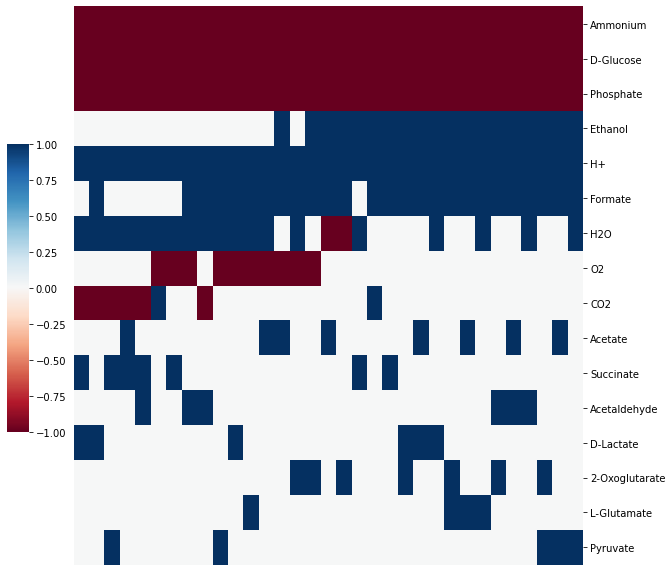

In [77]:
# Render mps
g = sns.clustermap(mp_df, cmap='RdBu', xticklabels=0)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.subplots_adjust(right=0.9)
g.ax_cbar.set_position((0.1, .2, .03, .4))
plt.savefig('results/figures/mps_ecolic', bbox_inches='tight')

### ECM and MP comparison for e_coli_core

#### Create a set of metabolites for each ECM

In [78]:
# Find metabolites that are both consumed and produced
strict_metabs = (ecm_df<=0).all(axis=0) | (ecm_df>=0).all(axis=0)
rev_metabs = [metab for metab, strict in strict_metabs.iteritems() if not strict]
rev_names = ['{} rev'.format(metab) for metab in rev_metabs]

# Make new columns for "reversible metabolites"
for metab, reversible in zip(rev_metabs, rev_names):
    ecm_df[reversible] = ecm_df[metab]
    ecm_df[metab] = ecm_df[metab].clip(lower=0)
    ecm_df[reversible] = ecm_df[reversible].clip(upper=0)

# Rename metabolites that are only consumed
rev_metabs = (ecm_df<=0).all(axis=0)
rev_metabs = [metab for metab, neg in rev_metabs.iteritems() if neg and not metab.endswith(' rev')]

for metab in rev_metabs:
    ecm_df.rename(columns={metab:'{} rev'.format(metab)}, inplace=True)

# Represent each ecm as a set of metabolites
ecms = []
for ecm in range(ecm_df.shape[0]):
    ecms.append(set(ecm_df.columns[ecm_df.iloc[ecm]!=0]))

#### Create a comparable set of metabolites for each MP

In [79]:
# Rename the metabolites in each set
mps = []
for i in range(len(mps_id)):
    mps.append(set(names.get(metab) for metab in mps_id[i]))

#### Compare sets

In [80]:
# Inspection of MPs that are subset of ECMs
# Which metabolites are not present in the MPs that are subsets of a given ECM?
for ecm in ecms:
    print()
    print(ecm)
    for mp in mps:
        if mp<=ecm:
            print(mp - ecm)

# For ECM 1, how do the MPs differ from the ECMs and vice versa?
for mp in mps:
    print('--------')
    print(mp - ecms[1])
    print(ecms[1] - mp)


{'H+', 'Ammonium rev', 'O2 rev', 'Phosphate rev', 'Formate', 'D-Glucose rev', 'Ethanol', '2-Oxoglutarate'}
set()

{'H+', 'Ammonium rev', 'D-Lactate', 'Phosphate rev', 'Formate', 'D-Glucose rev', 'H2O', 'Succinate', 'CO2 rev'}
set()
set()

{'H+', 'Ammonium rev', 'Phosphate rev', 'D-Glucose rev', 'H2O', 'Ethanol', '2-Oxoglutarate', 'Succinate', 'CO2 rev'}
set()

{'H+', 'Ammonium rev', 'L-Glutamate', 'Phosphate rev', 'Formate', 'D-Glucose rev', 'Ethanol', 'CO2'}
set()

{'H+', 'Ammonium rev', 'O2 rev', 'Phosphate rev', 'D-Glucose rev', 'H2O', 'CO2', 'Succinate'}
set()
set()

{'H+', 'Ammonium rev', 'O2 rev', 'Phosphate rev', 'D-Glucose rev', 'H2O', 'Acetaldehyde', 'CO2'}
set()

{'H+', 'Ammonium rev', 'Phosphate rev', 'Formate', 'D-Glucose rev', 'H2O', 'Acetate', 'Acetaldehyde', 'Succinate', 'CO2 rev'}
set()
set()
set()

{'H+', 'Ammonium rev', 'Pyruvate', 'L-Glutamate', 'O2 rev', 'Phosphate rev', 'D-Glucose rev', 'H2O', 'CO2'}
set()

{'H+', 'Ammonium rev', 'Pyruvate', 'O2 rev', 'Phosphate r

In [81]:
# Visualize ECM and MP comparison. How many subsets can we find for each MP?

# Calculate Jaccard distance between all MPs and ECMs
dist = np.zeros((len(mps), len(ecms)))
for i, mp in enumerate(mps):
    for j, ecm in enumerate(ecms):
        if mp<=ecm:
            dist[i,j] = len(mp & ecm)/len(mp | ecm)
        else:
            dist[i,j] = 0

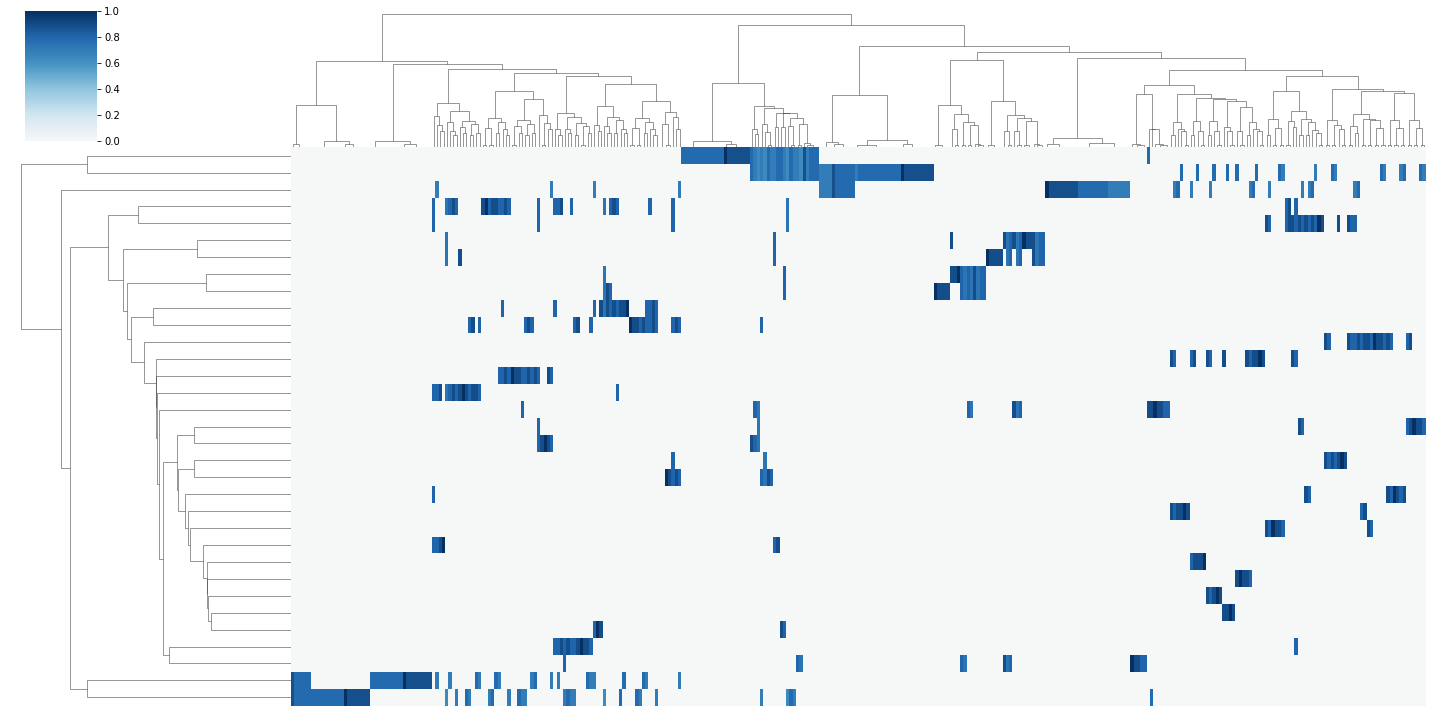

In [82]:
# Clustered heatmap of similarity
sns.clustermap(dist, col_cluster=True, cmap='RdBu', xticklabels=0, yticklabels=0, center=0, method = 'ward', figsize=(20, 10))
plt.savefig('results/figures/cluster_ecoli')

In [83]:
# Any metabolites missing?
print(set.union(*ecms)-set.union(*mps), set.union(*mps)-set.union(*ecms))

set() set()


In [84]:
# Number of MPs that are a subset for each ECM
counts_mps = []
for ecm in ecms:
    count = 0
    for mp in mps:
        if mp<=ecm:
            count += 1
    if count == 0:
        print(ecm)
    counts_mps.append(count)

{'H+', 'Ammonium rev', 'Phosphate rev', 'Formate', 'D-Glucose rev', 'H2O', 'Succinate', 'CO2 rev'}
{'H+', 'Ammonium rev', 'Phosphate rev', 'Formate', 'D-Glucose rev', 'H2O', '2-Oxoglutarate', 'Succinate', 'CO2 rev'}


There are 2 ECMs in which no MP is a subset of. I will try to further incpect these ECMs.

In [85]:
# The ECMs with no MP subset
what1 = {'H+', 'Formate', 'Phosphate rev', 'H2O', 'D-Glucose rev', 'CO2 rev', 'Ammonium rev', 'Succinate'}
what2 = {'H+', 'Formate', 'Phosphate rev', 'H2O', 'D-Glucose rev', '2-Oxoglutarate', 'CO2 rev', 'Ammonium rev', 'Succinate'}

In [86]:
# Print differences between each MP and the ECMs in question
for mp in mps:
    print(mp - what2)
    print(what2 - mp)
    print('--------')

{'O2 rev', 'CO2'}
{'2-Oxoglutarate', 'Formate', 'Succinate', 'CO2 rev'}
--------
{'Ethanol', 'CO2'}
{'H2O', '2-Oxoglutarate', 'Succinate', 'CO2 rev'}
--------
{'Ethanol'}
{'2-Oxoglutarate', 'Formate', 'CO2 rev'}
--------
{'Ethanol'}
{'H2O', '2-Oxoglutarate', 'CO2 rev'}
--------
{'O2 rev'}
{'2-Oxoglutarate', 'Formate', 'CO2 rev'}
--------
{'Acetate', 'L-Glutamate', 'Ethanol'}
{'H2O', '2-Oxoglutarate', 'Succinate', 'CO2 rev'}
--------
{'Acetate', 'O2 rev'}
{'2-Oxoglutarate', 'Succinate', 'CO2 rev'}
--------
{'Acetate'}
{'2-Oxoglutarate', 'Formate'}
--------
{'Acetate', 'O2 rev', 'Ethanol'}
{'H2O', '2-Oxoglutarate', 'Succinate', 'CO2 rev'}
--------
{'Pyruvate', 'Acetate', 'Ethanol'}
{'H2O', '2-Oxoglutarate', 'Succinate', 'CO2 rev'}
--------
{'Acetate', 'H2O rev', 'Ethanol'}
{'H2O', '2-Oxoglutarate', 'Succinate', 'CO2 rev'}
--------
{'Acetate', 'Ethanol', 'D-Lactate'}
{'H2O', '2-Oxoglutarate', 'Succinate', 'CO2 rev'}
--------
{'Acetate', 'Acetaldehyde', 'Ethanol'}
{'H2O', '2-Oxoglutarate',

In [87]:
# Number of MPs that are a subset for each ECM
counts_mps = []
for ecm in ecms:
    count = 0
    for mp in mps:
        if mp<=ecm:
            count += 1
    counts_mps.append(count)

In [88]:
# How many ECMs did not have a subset of metabolites that corresponded to an MP?
zeros_mps = [x for x in counts_mps if x == 0]
print(len(zeros_mps))

2


In [89]:
# Number of ECMs that are a superset of each MP.
counts_ecms = []
for mp in mps:
    count = 0
    for ecm in ecms:
        if mp<=ecm:
            count += 1
    counts_ecms.append(count)

In [90]:
# How many MPs did not have a superset of metabolites that corresponded to an ECM?
zeros_ecms = [x for x in counts_ecms if x == 0]
print(len(zeros_ecms))

counts_ecms = [x for x in counts_ecms if x>0]

0


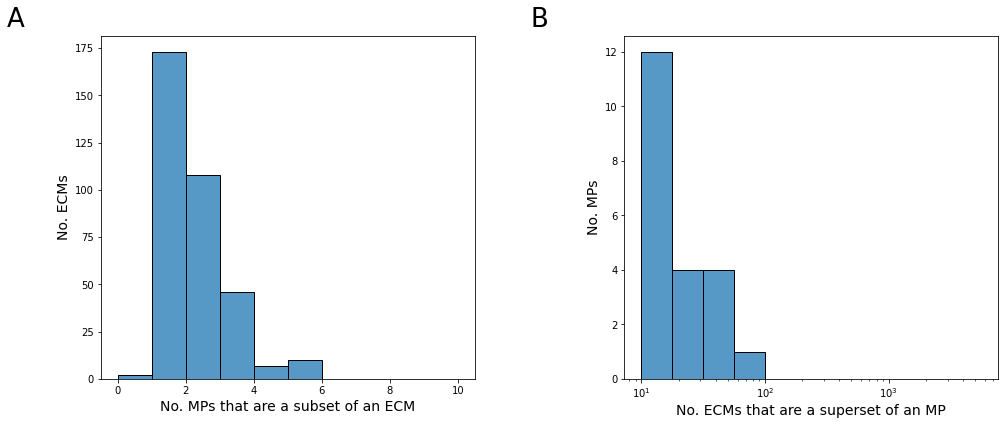

In [91]:
# Plot histograms
f = plt.figure()
#f.suptitle('Counts of subsets of metabolites for e_coli_core', fontsize=18)


plt.subplot(1,2,1)
ax = sns.histplot(counts_mps, binwidth=1, binrange=(0,10))
ax.text(-0.25, 1.025, 'A', transform=ax.transAxes, size=26)
plt.xlabel('No. MPs that are a subset of an ECM', fontsize=14)
plt.ylabel('No. ECMs', fontsize=14)

plt.subplot(1,2,2)
ax = sns.histplot(counts_ecms, stat='count', log_scale=True, bins=np.arange(1,4,0.25))
ax.text(-0.25, 1.025, 'B', transform=ax.transAxes, size=26)
plt.xlabel('No. ECMs that are a superset of an MP', fontsize=14)
plt.ylabel('No. MPs', fontsize=14)

f.set_size_inches(14, 6)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
f.savefig('results/figures/hist_e_coli_core')


# iIT341 on minII medium

### Visualize all ECMs

In [26]:
# Read results
df = pd.read_csv('results/ecm/iIT_minII.csv')

In [27]:
# Filter rows according to sign of metabolite exchange
sign_df = np.sign(df)
unique_df = sign_df.drop_duplicates()

# Filter away unused metabolites
unique_df = unique_df.loc[:, (unique_df != 0).any(axis = 0)]

# Filter ECMs that produce biomass
unique_df = unique_df.loc[unique_df['objective']!=0]

# Remove biomass column
ecm_df = unique_df.drop('objective', axis=1)

In [28]:
# For reproduction of plot in supplementary file of ecmtool article (Clement et al., 2021)

# Filter away ECMs where acetate was not produced
#acetate_prod = unique_df.loc[unique_df['M_ac_e'] > 0, ]

# Filter away ECMs where L-alanine was taken up
#simplified_df = acetate_prod.loc[acetate_prod['M_ala__L_e'] >= 0, ]
#simplified_df = simplified_df.drop('M_ala__L_e', axis=1)

In [29]:
# Make informational column names i.e. translate metabolite ID to metabolite name

# Read translation file
metabfile = open('raw_data_from_publications/metabolite_names_iIT341.txt')
metabnames = metabfile.readlines()

# Make ID:name dictionary
id_to_name = dict()
for line in metabnames:
    id_to_name[line.split()[1]] = ' '.join(line.split()[2:-2])

# Edit some names manually
id_to_name['M_h2o_e'] = 'H2O'
id_to_name['M_co2_e'] = 'CO2'
id_to_name['M_o2_e'] = 'O2'
id_to_name['M_urea_e'] = 'Urea'
id_to_name['M_fe2_e'] = 'Fe2+'
    
# Subset column names
column_names = {ID: id_to_name[ID] for ID in ecm_df.columns}

# Rename all columns
ecm_df = ecm_df.rename(columns=column_names)

In [30]:
ecm_df.shape

(125020, 45)

In [31]:
# Failed attempt at row and column clustering. The dataset was too large.
#from scipy.spatial.distance import pdist
#pdist(ecm_df.values, 'euclid')

#clustered_ecm = fastcluster.linkage(ecm_df.T, method = 'average', metric='euclidean')
#g = sns.clustermap(ecm_df.T, col_linkage=clustered_ecm, cmap='RdBu', xticklabels=0, center=0)
#clustered_ecm.shape

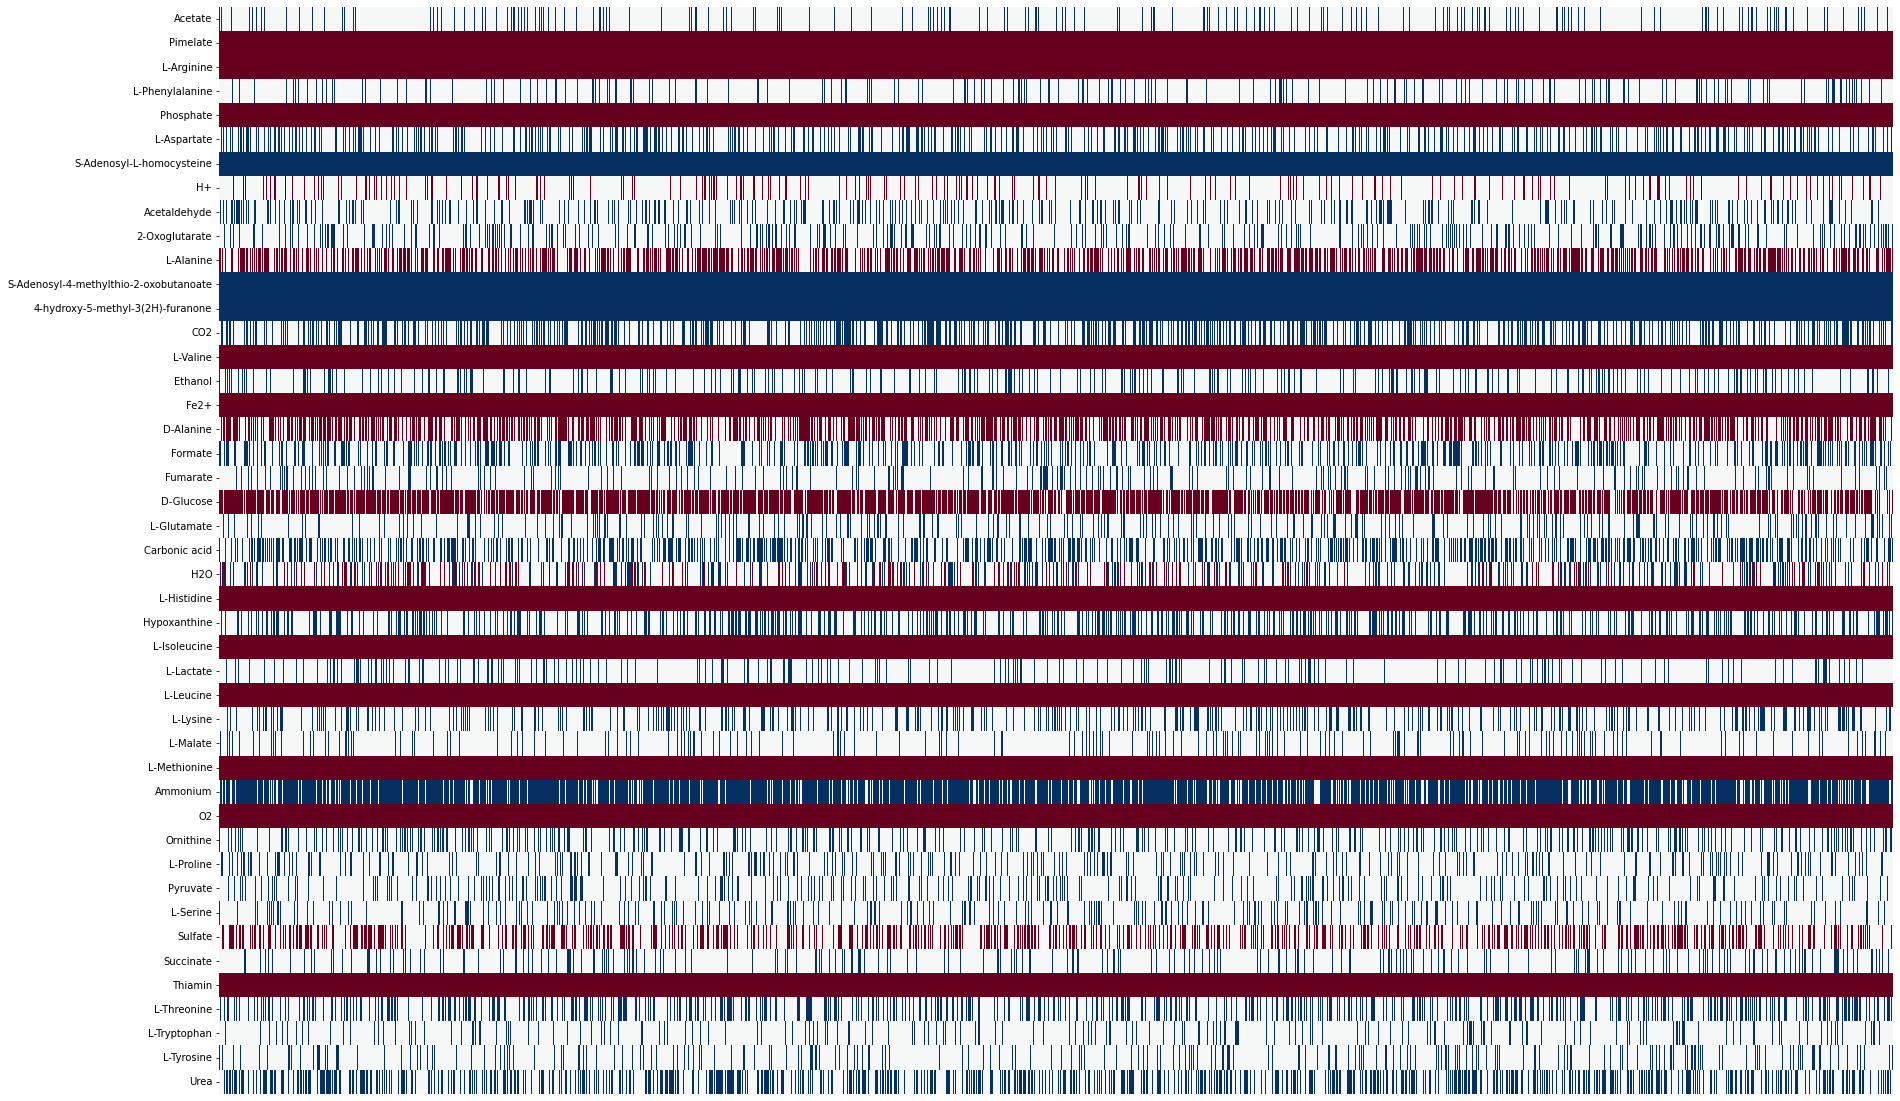

In [32]:
# Render figure.
figure = plt.figure(figsize=(30,20))
g = sns.heatmap(ecm_df.T, cmap='RdBu', xticklabels=0, yticklabels=1, center=0, cbar=False)
#g.set_yticklabels(ecm_df.columns, fontsize = 18)
#sns.set(rc = {'figure.figsize':(30,20)})
figure.savefig('results/figures/ecms_HP', bbox_inches='tight')

### Visualize all MPs

In [33]:
# Read mps from csv file
mps_id = []
with open('results/mp/iIT341_20220425_174554948108_complete_mps.csv', newline='\n') as mpfile:
    mps_in_csv = csv.reader(mpfile, delimiter = ',')
    for mp in mps_in_csv:
        mps_id.append(set(mp))

In [34]:
# Create clustered heatmap visualizing which metabolites are present in each mp
mp_df = pd.DataFrame({i: {x: 1 for x in mp} for i, mp in enumerate(mps_id)}).fillna(0)

In [35]:
# For comparison of reproduction of plot in supplementary file of ecmtool article (Clement et al., 2021)

# Filter MPs that produce acetate and don't take up L-alanine
#for col in mp_df:
#   if mp_df.loc['EX_ac_e', col]==0 and mp_df.loc['EX_ala__L_e_rev', col]>0:
#       mp_df.pop(col)

In [36]:
# Change sign on metabolites that are consumed
for row in mp_df.index:
    if row.endswith('rev'):
        mp_df.loc[row,] = mp_df.loc[row, ].replace(to_replace=1, value=-1)

# Find metabolites which are both consumed and produced
consumed = [row for row in mp_df.index if row.endswith('rev')]
reversible = [row.replace('_rev', '') for row in consumed if row.replace('_rev', '') in mp_df.index]

# Merge the forward and reverse rows
for row in reversible:
    for col in mp_df:
        if mp_df.loc[row + '_rev', col] < 0:
            mp_df.loc[row, col] = -1
    mp_df = mp_df.drop(index = row + '_rev', axis=0)

In [37]:
# Read dictionary of sensible names for plotting
names = dict()
f = open("results/mp/iIT341_metabnames_mps.csv", newline = '\n')
for line in f:
    line = line.strip('\r\r\n')
    (key, val) = line.split(",")
    names[key] = val

# Extend dictionary for reverse metabolites
for metab in set.union(*mps_id):
    if metab.endswith('_rev'):
        names[metab] = '{} reverse'.format(names[metab.replace('_rev', '')])

# Subset row names
row_names = {ID: names[ID] for ID in mp_df.index}

# Rename all rows
mp_df = mp_df.rename(index = row_names)

# Remove 'reverse' label
mp_df = mp_df.rename(index=lambda x: x.replace(' reverse', ''))

In [38]:
mp_df.shape

(45, 1382)

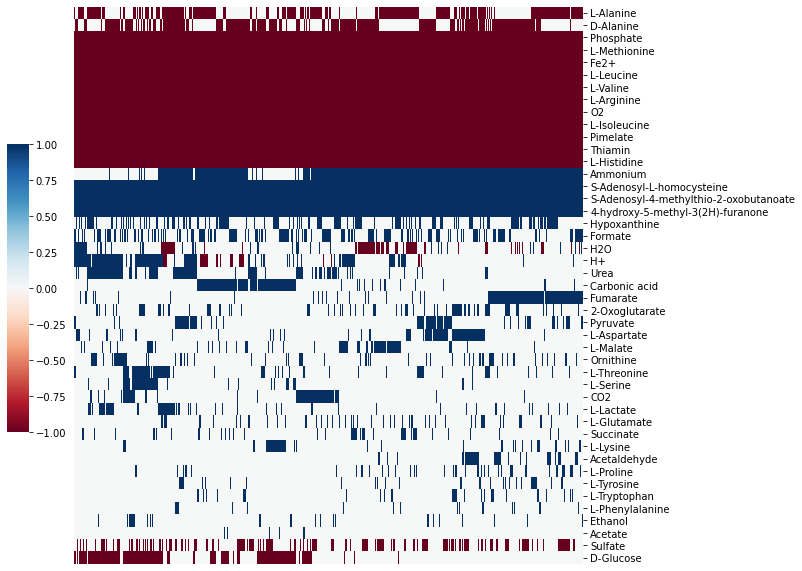

In [39]:
# Render figure
g = sns.clustermap(mp_df, cmap='RdBu', xticklabels=0, yticklabels=mp_df.index)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.subplots_adjust(right=0.9)
g.ax_cbar.set_position((0.1, .2, .03, .4))
plt.savefig('results/figures/mps_HP', bbox_inches='tight')

### ECM and MP comparison for iIT341 on minII medium

#### Make each ECM a set of metabolites

In [40]:
# Find metabolites that are both consumed and produced
strict_metabs = (ecm_df<=0).all(axis=0) | (ecm_df>=0).all(axis=0)
rev_metabs = [metab for metab, strict in strict_metabs.iteritems() if not strict]
rev_names = ['{} reverse'.format(metab) for metab in rev_metabs]

# Make new columns for "reversible metabolites" (metabolites that are both produced and consumed in the set of ECMs)
for metab, reversible in zip(rev_metabs, rev_names):
    ecm_df[reversible] = ecm_df[metab]
    ecm_df[metab] = ecm_df[metab].clip(lower=0)
    ecm_df[reversible] = ecm_df[reversible].clip(upper=0)

# Rename metabolites that are only consumed
rev_metabs = (ecm_df<=0).all(axis=0)
rev_metabs = [metab for metab, neg in rev_metabs.iteritems() if neg and not metab.endswith(' reverse')]

for metab in rev_metabs:
    ecm_df.rename(columns={metab:'{} reverse'.format(metab)}, inplace=True)

# Represent each ecm as a set of metabolites
ecms = []
for ecm in range(ecm_df.shape[0]):
    ecms.append(set(ecm_df.columns[ecm_df.iloc[ecm]!=0]))

#### Create a comparable set of metabolites for each MP

In [41]:
# Rename the metabolites in each set
mps = []
for i in range(len(mps_id)):
    mps.append(set(names.get(metab) for metab in mps_id[i]))

#### Compare sets

In [42]:
# Visualize ECM and MP comparison. How many subsets can we find for each MP?

# Calculate Jaccard distance between all MPs and ECMs
#dist = np.zeros((len(mps), len(ecms)))
#for i, mp in enumerate(mps):
 #   for j, ecm in enumerate(ecms):
  #      if mp<=ecm:
   #         dist[i,j] = len(mp & ecm)/len(mp | ecm)
   #     else:
    #        dist[i,j] = 0

In [43]:
# Clustered heatmap of similarity
# g = sns.heatmap(dist, cmap='RdBu', xticklabels=0, yticklabels=0, center=0)

We may not be able to visualize full heatmap where all ECMs and MPs are visible like for `e_coli_core`. To summarize the connection between MPs and ECMs, for each ECM, we count how many MPs that are a subset for each ECM. Equivalently, for each MP, we count how many MPs that are a subset of ECMs.

In [44]:
# Number of MPs that are a subset for each ECM
counts_mps = []
for ecm in ecms:
    count = 0
    for mp in mps:
        if mp<=ecm:
            count += 1
    counts_mps.append(count)

In [45]:
# How many ECMs did not have a subset of metabolites that corresponded to an MP?
zeros_mps = [x for x in counts_mps if x == 0]
print(len(zeros_mps))

12954


In [46]:
# Number of ECMs that are a superset of each MP.
counts_ecms = []
for mp in mps:
    count = 0
    for ecm in ecms:
        if mp<=ecm:
            count += 1
    counts_ecms.append(count)

In [47]:
# How many MPs did not have a superset of metabolites that corresponded to an ECM?
zeros_ecms = [x for x in counts_ecms if x == 0]
print(len(zeros_ecms))

counts_ecms = [x for x in counts_ecms if x>0]

520


In [48]:
print(min(counts_ecms), max(counts_ecms))
print(min(counts_mps), max(counts_mps))

26 2133
0 9


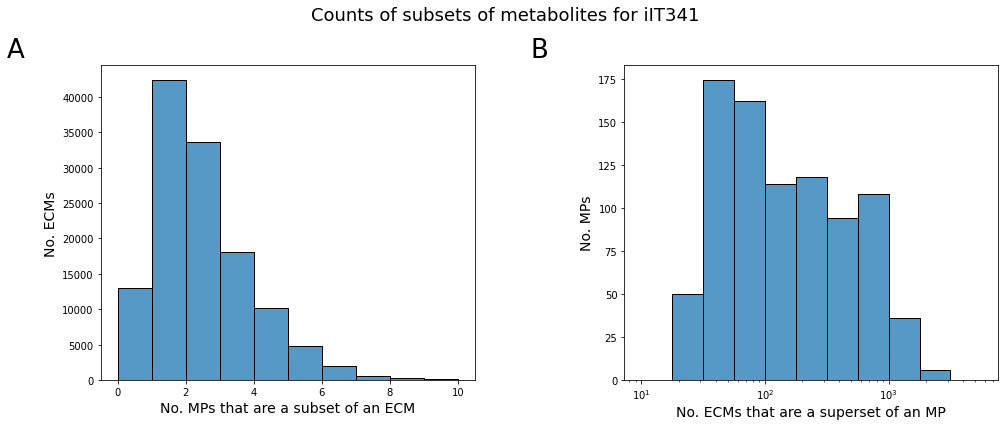

In [59]:
# Plot histograms
f = plt.figure()
f.suptitle('Counts of subsets of metabolites for iIT341', fontsize=18)

plt.subplot(1,2,1)
ax = sns.histplot(counts_mps, binwidth=1, binrange=(0,10))
ax.text(-0.25, 1.025, 'A', transform=ax.transAxes, size=26)
plt.xlabel('No. MPs that are a subset of an ECM', fontsize=14)
plt.ylabel('No. ECMs', fontsize=14)

plt.subplot(1,2,2)
ax = sns.histplot(counts_ecms, stat='count', log_scale=True, bins=np.arange(1,4,0.25))
ax.text(-0.25, 1.025, 'B', transform=ax.transAxes, size=26)
plt.xlabel('No. ECMs that are a superset of an MP', fontsize=14)
plt.ylabel('No. MPs', fontsize=14)

f.set_size_inches(14, 6)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
f.savefig('results/figures/hist_iIT341')

In [60]:
print(set.union(*mps) - set.union(*ecms))
print(set.union(*ecms) - set.union(*mps))

set()
set()


There are 12 954 ECMs which no MP is a subset of. We also find 520 MPs that are not a subset of any ECM. What might explain this  discrepancy is that some MPs seems to include production of acid (H+), but none of the ECMs do this. For now, I remove H+ from the comparisons to see if the similarities improve. 

In [61]:
for s in itertools.chain(mps, ecms):
    s.difference_update(['H+', 'H+ reverse'])

In [62]:
# Number of MPs that are a subset for each ECM
counts_mps_woh = []
for ecm in ecms:
    count = 0
    for mp in mps:
        if mp<=ecm:
            count += 1
    counts_mps_woh.append(count)

In [63]:
# How many ECMs did not have a subset of metabolites that corresponded to an MP?
zeros_mps_woh = [x for x in counts_mps_woh if x == 0]
print(len(zeros_mps_woh))

468


In [64]:
# Number of ECMs that are a superset for each MP
counts_ecms_woh = []
for mp in mps:
    count = 0
    for ecm in ecms:
        if mp<=ecm:
            count += 1
    counts_ecms_woh.append(count)

In [65]:
# How many MPs did not have a superset of metabolites that corresponded to an ECM?
zeros_ecms_woh = [x for x in counts_ecms_woh if x == 0]
print(len(zeros_ecms_woh))

counts_ecms_woh = [x for x in counts_ecms_woh if x>0]

152


In [66]:
print(min(counts_ecms_woh), max(counts_ecms_woh))
print(min(counts_mps_woh), max(counts_mps_woh))

1 5763
0 18


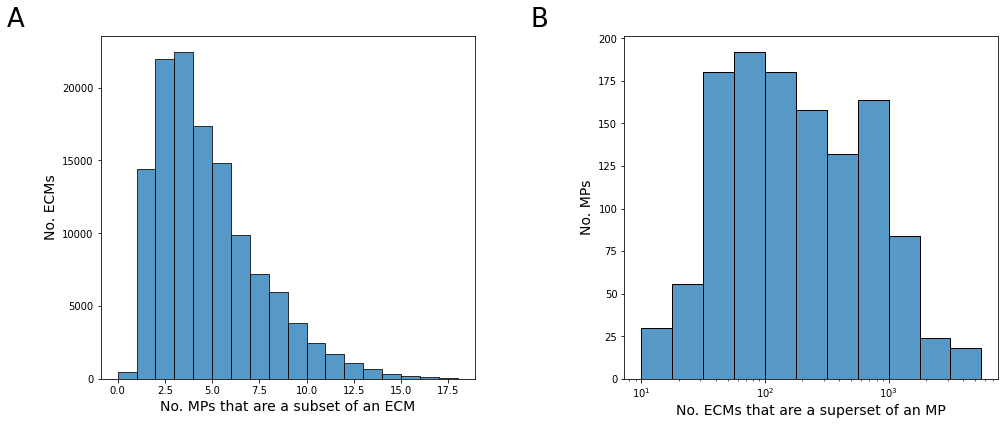

In [68]:
# Plot histograms
f = plt.figure()
#f.suptitle('Counts of subsets of metabolites for iIT341', fontsize = 18)

plt.subplot(1,2,1)
ax = sns.histplot(counts_mps_woh, stat='count', binwidth=1, binrange=(0,18))
ax.text(-0.25, 1.025, 'A', transform=ax.transAxes, size=26)
plt.xlabel('No. MPs that are a subset of an ECM', fontsize = 14)
plt.ylabel('No. ECMs', fontsize=14)

plt.subplot(1,2,2)
ax = sns.histplot(counts_ecms_woh, stat='count', log_scale=True, bins=np.arange(1,4,0.25))
ax.text(-0.25, 1.025, 'B', transform=ax.transAxes, size=26)
plt.xlabel('No. ECMs that are a superset of an MP', fontsize = 14)
plt.ylabel('No. MPs', fontsize=14)

f.set_size_inches(14, 6)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
f.savefig('results/figures/hist_iIT341_woh')

There are still 468 ECMs with no MP subset and 152 MPs without an ECM superset, meaining there is still not a full overlap. I also notice that 468 and 152 sums to 520, which was the number of MPs missing ECMs before removing H+.

# iIT341 hide

### Visualize ECMs

In [62]:
df = pd.read_csv('results/ecm/iIT_hide.csv')

In [63]:
# Filter rows according to sign of metabolite exchange
sign_df = np.sign(df)
unique_df = sign_df.drop_duplicates()

# Filter away unused metabolites
unique_df = unique_df.loc[:, (unique_df != 0).any(axis = 0)]

# Filter ECMs that produce biomass
unique_df = unique_df.loc[unique_df['objective']!=0]

# Remove biomass column
ecm_df = unique_df.drop('objective', axis=1)

In [64]:
ecm_df.shape

(32, 17)

In [65]:
# Subset column names
column_names = {ID: id_to_name[ID] for ID in ecm_df.columns}

# Rename all columns
ecm_df = ecm_df.rename(columns = column_names)

In [66]:
# For reproduction of heatmap presented in ecmtool paper
#dropcols = ['Thiamin', 'L-Methionine', 'L-Leucine', 'L-Isoleucine', 'L-Histidine', 'Fe2+ mitochondria', 'L-Valine', 
#           'Pimelate', 'Phosphate']
#unique_df = unique_df.drop(columns=dropcols)
#unique_df.shape

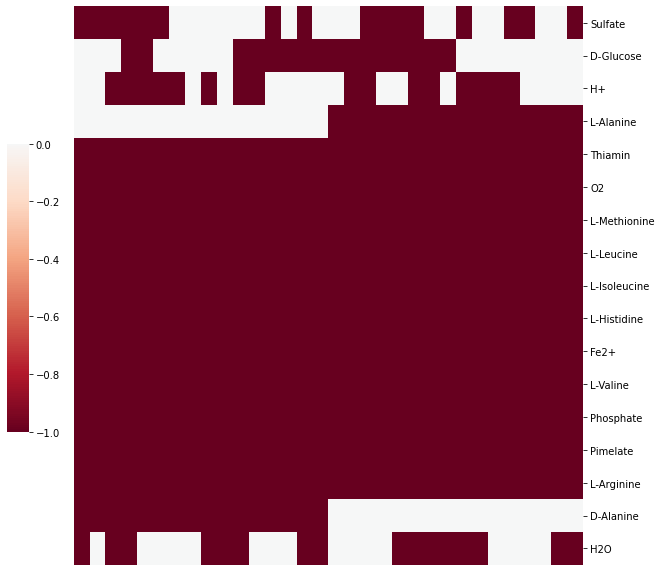

In [67]:
# Render figure
cmap = sns.clustermap(ecm_df.T, cmap='RdBu', center=0, xticklabels=0)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)
cmap.fig.subplots_adjust(right=0.9)
cmap.ax_cbar.set_position((0.1, .2, .03, .4))
plt.savefig('results/figures/ecms_hideoutputs', bbox_inches='tight')

### Visualize MPs

In [68]:
# Read mps from csv file
mps_id = []
with open('results/mp/iIT341_20220502_1108577312872_complete_mps.csv', newline='\n') as mpfile:
    mps_in_csv = csv.reader(mpfile, delimiter = ',')
    for mp in mps_in_csv:
        mps_id.append(set(mp))

In [69]:
# Create clustered heatmap visualizing which metabolites are present in each mp
mp_df = pd.DataFrame({i: {x: 1 for x in mp} for i, mp in enumerate(mps_id)}).fillna(0)

In [70]:
# Change sign on metabolites that are consumed
for row in mp_df.index:
    if row.endswith('rev'):
        mp_df.loc[row,] = mp_df.loc[row, ].replace(to_replace=1, value=-1)

# Find metabolites which are both consumed and produced
consumed = [row for row in mp_df.index if row.endswith('rev')]
reversible = [row.replace('_rev', '') for row in consumed if row.replace('_rev', '') in mp_df.index]

# Merge the forward and reverse rows
for row in reversible:
    for col in mp_df:
        if mp_df.loc[row + '_rev', col] < 0:
            mp_df.loc[row, col] = -1
    mp_df = mp_df.drop(index = row + '_rev', axis=0)

In [71]:
# Subset row names
row_names = {ID: names[ID] for ID in mp_df.index}

# Rename all rows
mp_df = mp_df.rename(index = row_names)

# Remove 'reverse' label
mp_df = mp_df.rename(index=lambda x: x.replace(' reverse', ''))

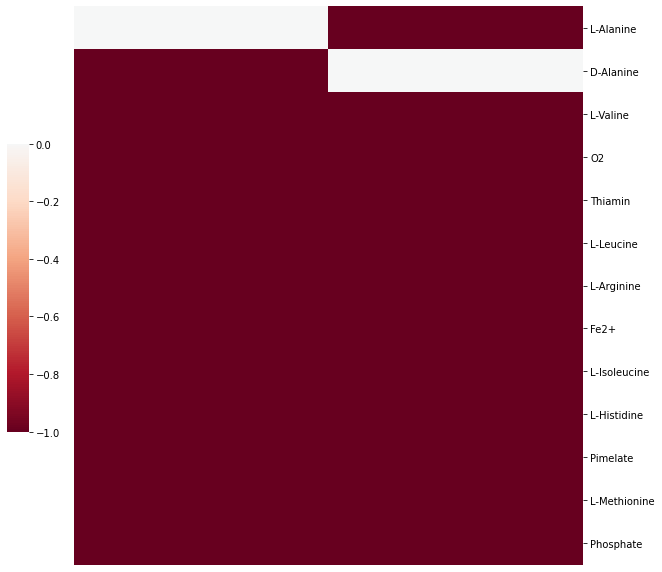

In [72]:
# Render figure
g = sns.clustermap(mp_df, cmap='RdBu', center=0, xticklabels=0)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.subplots_adjust(right=0.9)
g.ax_cbar.set_position((0.1, .2, .03, .4))
plt.savefig('results/figures/mps_hideoutputs', bbox_inches='tight')

### ECM and MP comparison for iIT341 hide outputs

#### Make each ECM a set of metabolites

In [73]:
# Find metabolites that are both consumed and produced
strict_metabs = (ecm_df<=0).all(axis=0) | (ecm_df>=0).all(axis=0)
rev_metabs = [metab for metab, strict in strict_metabs.iteritems() if not strict]
rev_names = ['{} reverse'.format(metab) for metab in rev_metabs]

# Make new columns for "reversible metabolites" (metabolites that are both produced and consumed in the set of ECMs)
for metab, reversible in zip(rev_metabs, rev_names):
    ecm_df[reversible] = ecm_df[metab]
    ecm_df[metab] = ecm_df[metab].clip(lower=0)
    ecm_df[reversible] = ecm_df[reversible].clip(upper=0)

# Rename metabolites that are only consumed
rev_metabs = (ecm_df<=0).all(axis=0)
rev_metabs = [metab for metab, neg in rev_metabs.iteritems() if neg and not metab.endswith(' reverse')]

for metab in rev_metabs:
    ecm_df.rename(columns={metab:'{} reverse'.format(metab)}, inplace=True)

# Represent each ecm as a set of metabolites
ecms = []
for ecm in range(ecm_df.shape[0]):
    ecms.append(set(ecm_df.columns[ecm_df.iloc[ecm]!=0]))

#### Create a comparable set of metabolites for each MP

In [74]:
# Rename the metabolites in each set
mps = []
for i in range(len(mps_id)):
    mps.append(set(names.get(metab) for metab in mps_id[i]))

#### Compare sets

In [75]:
# Visualize ECM and MP comparison. How many subsets can we find for each MP?

# Calculate Jaccard distance between all MPs and ECMs
dist = np.zeros((len(mps), len(ecms)))
for i, mp in enumerate(mps):
    for j, ecm in enumerate(ecms):
        if mp<=ecm:
            dist[i,j] = len(mp & ecm)/len(mp | ecm)
        else:
            dist[i,j] = 0

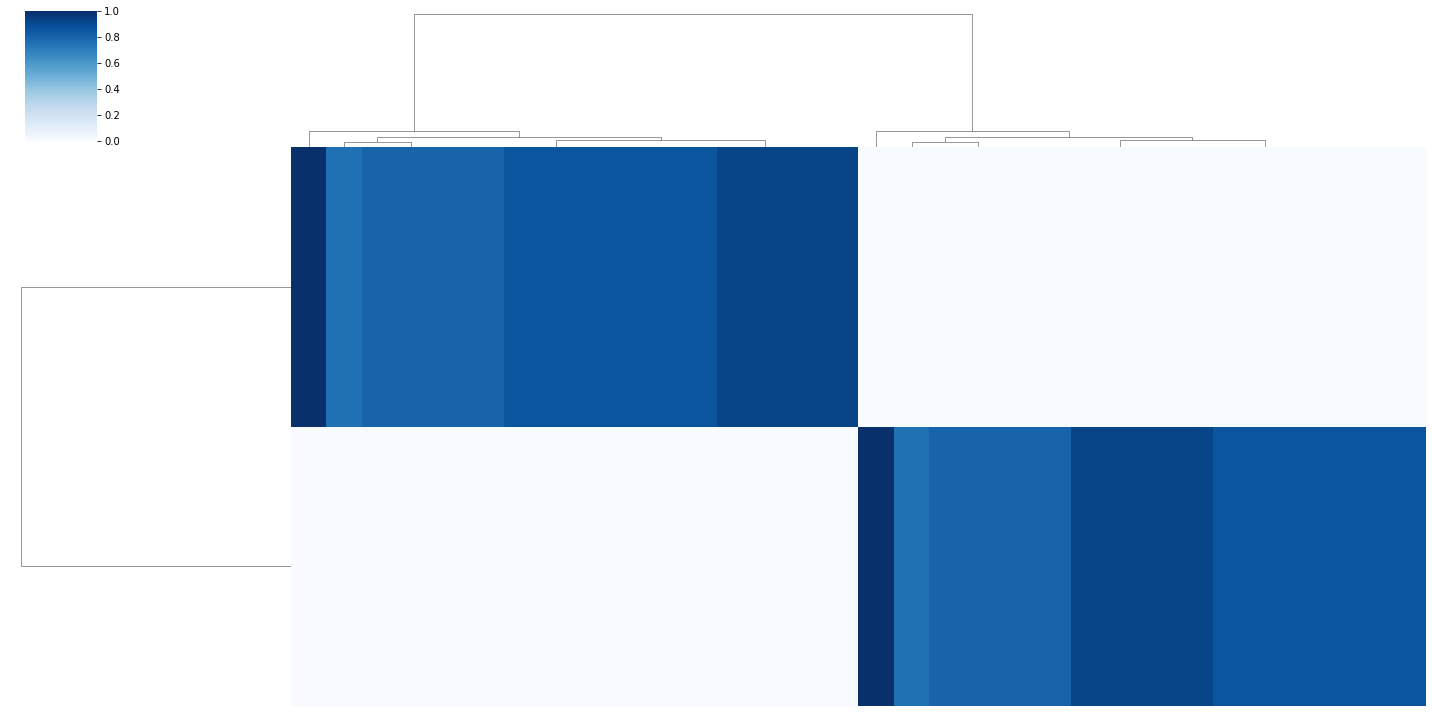

In [76]:
# Clustered heatmap of similarity
g = sns.clustermap(dist, col_cluster=True, cmap='Blues', xticklabels=0, yticklabels=0, figsize=(20, 10))
plt.savefig('results/figures/cluster_hideoutputs')

In [77]:
# Number of MPs that are a subset for each ECM
counts_mps = []
for ecm in ecms:
    count = 0
    for mp in mps:
        if mp<=ecm:
            count += 1
    counts_mps.append(count)

In [78]:
# How many ECMs did not have a subset of metabolites that corresponded to an MP?
zeros_mps = [x for x in counts_mps if x == 0]
print(len(zeros_mps))

0


In [79]:
# Number of ECMs that are a superset of each MP.
counts_ecms = []
for mp in mps:
    count = 0
    for ecm in ecms:
        if mp<=ecm:
            count += 1
    counts_ecms.append(count)

In [80]:
# How many MPs did not have a superset of metabolites that corresponded to an ECM?
zeros_ecms = [x for x in counts_ecms if x == 0]
print(len(zeros_ecms))

counts_ecms = [x for x in counts_ecms if x>0]

0


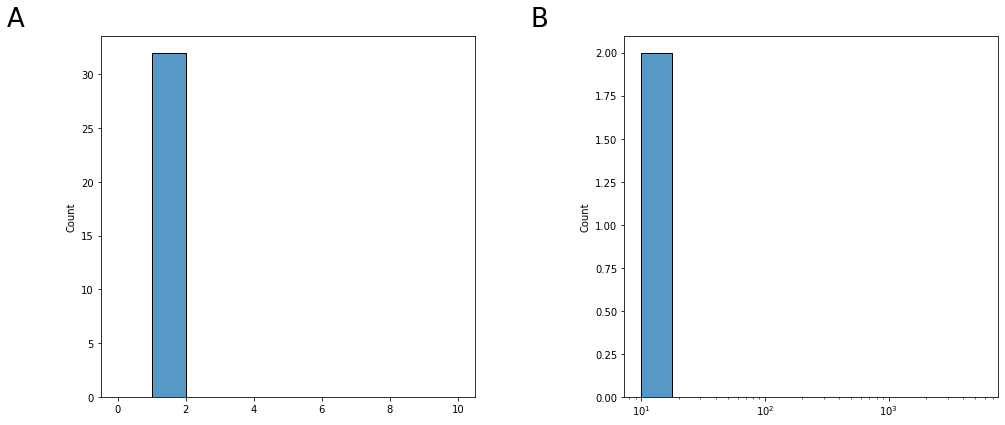

In [81]:
# Plot histograms
f = plt.figure()

plt.subplot(1,2,1)
ax = sns.histplot(counts_mps, binwidth=1, binrange=(0,10))
ax.text(-0.25, 1.025, 'A', transform=ax.transAxes, size=26)

plt.subplot(1,2,2)
ax = sns.histplot(counts_ecms, stat='count', log_scale=True, bins=np.arange(1,4,0.25))
ax.text(-0.25, 1.025, 'B', transform=ax.transAxes, size=26)

f.set_size_inches(14, 6)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
f.savefig('results/figures/hist_iIT341_only_inputs')

# Mat commumity

### ECMs

In [45]:
microbes = ['fap', 'srb', 'syn']

ecm_dfs = []
for microbe in microbes:
    ecm_df = pd.read_csv(f'results/ecm/{microbe}.csv')
    
    # Convert stoichiometry to fractions, THEN convert to floats
    #ecm_df = ecm_df.applymap(frac)
    #ecm_df = ecm_df.applymap(float)
    
    # Filter rows according to sign of metabolite exchange
    ecm_df = np.sign(ecm_df)

    # Filter away unused metabolites
    ecm_df = ecm_df.loc[:, (ecm_df != 0).any(axis = 0)]

    # Filter ECMs that produce biomass
    ecm_df = ecm_df.loc[ecm_df['objective'] != 0]

    # Remove column with biomass and ATP
    #ecm_df = ecm_df.drop([f'M_bm_{microbe}', f'M_ATPex_{microbe}'], axis = 1)
    
    # Change index to organism name
    ecm_df['organism'] = [f'{microbe}' for m in range(0,ecm_df.shape[0])]
    ecm_df.set_index('organism', inplace=True)
    
    ecm_dfs.append(ecm_df)

In [46]:
# Concatenate dataframes
micmat_df = pd.concat([ecm_dfs[0], ecm_dfs[1], ecm_dfs[2]])
micmat_df.fillna(0, inplace=True)
micmat_df.drop_duplicates(inplace=True)

In [47]:
micmat_df.iloc[6]

M_ATPex_fap        0.0
M_CO2ex_gen        0.0
M_H2pool_gen      -1.0
M_NH3ex_gen       -1.0
M_bm_fap           1.0
M_hv_gen           0.0
M_glycpool_gen    -1.0
M_O2expool_gen    -1.0
M_ac_pool         -1.0
objective          1.0
M_SO4ex_gen        0.0
M_H2Sex_gen        0.0
M_ATPex_srb        0.0
M_bm_srb           0.0
M_polyglcex_gen    0.0
M_ATPex_syn        0.0
M_bm_syn           0.0
M_glyox_syn        0.0
Name: fap, dtype: float64

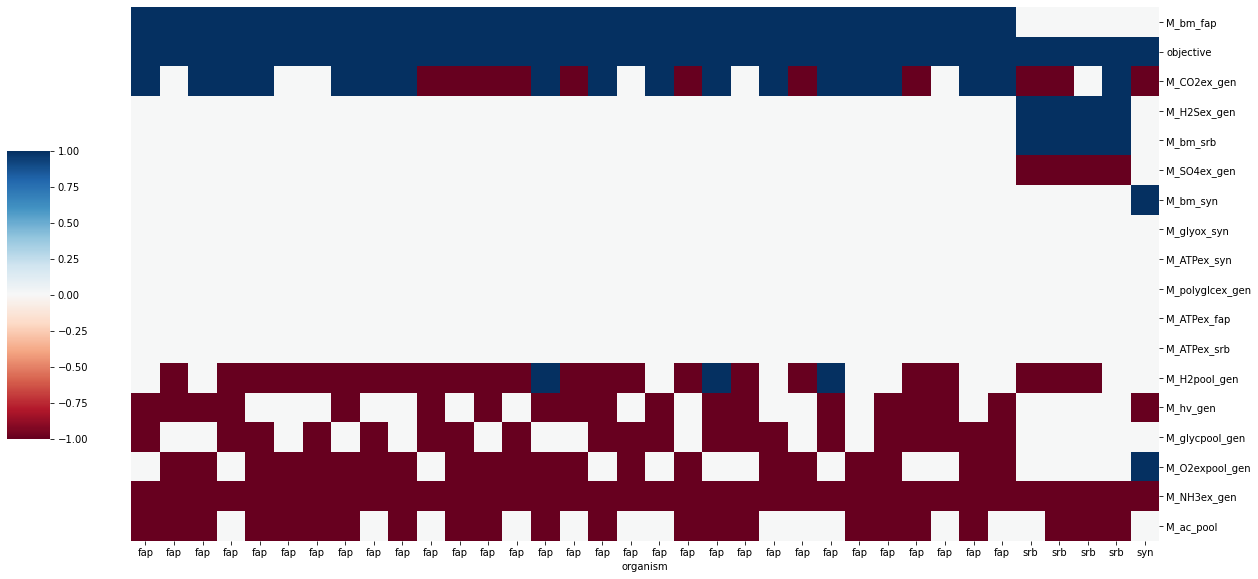

In [48]:
# Render figure
cmap = sns.clustermap(micmat_df.T, cmap='RdBu', col_cluster=False, figsize=(20, 10))
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)
cmap.fig.subplots_adjust(right=0.9)
cmap.ax_cbar.set_position((0.1, .2, .03, .4))
#plt.savefig('results/figures/ecms_ecolic', bbox_inches='tight')